# Information Retrieval Final Project - Neural Inverted Index

---

## 📝 Team Members
Navid Azimi, Alireza Rafiei, Mohammad Hashemi

---

## 📘 Overview of the Project
This project investigates a  methodology in information retrieval (IR), moving away from the conventional systems that separate indexing from retrieval. Drawing inspiration from the Differentiable Search Index (DSI) concept, we have developed a unified Transformer language model that integrates both indexing and retrieval processes. Trained using the MS MARCO dataset and enhanced with the Pyserini library, this model aims to enhance retrieval effectiveness by auto-regressively generating relevant document identifiers (docids).


#### Let's install the necessary libraries

In [16]:
#!pip install nltk
#!pip install pytorch_lightning
#!pip install gensim
#!pip install pyserini==0.12.0
#!pip install python-terrier
#!pip install ipywidgets
#!pip install --upgrade notebook jupyter
#!jupyter nbextension enable --py widgetsnbextension
#!pip install tensorboard tensorboardX
#!pip install torch-tb-profiler

  Obtaining dependency information for torch-tb-profiler from https://files.pythonhosted.org/packages/46/d0/891ec43349f287ea5c313ebc1320e4eda38ccd4c7a0951657213467eaab5/torch_tb_profiler-0.4.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00 0:00:01


#### Import libraries

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

import nltk
from gensim.models import Word2Vec

from src.dataset import mydataset
from src.utils import utils, dataset_utils, eval_utils, trie
from src.models import siamese, attention_siamese, siamese_triplet, s2stransformer, s2s_transf, s2s_transf_semantic

torch.manual_seed(2024)

#### Download necessary nltk packages

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alirezarafiei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alirezarafiei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alirezarafiei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Set some fixed variables

In [2]:
EMBEDDING_SIZE = 120
MAX_TOKENS = 7
K1 = 10      
K2 = 100
DOWNLOAD_FILES = False

QUERIES_PATH = './materials/queries.json'
DOCS_PATH = './materials/documents.json'
W2V_PATH = './materials/word2vec_model.bin'
BT_MOD_PATH = './materials/bt_model.pth'

#### Create files and embeddings

In [3]:
# If the json files of documents does not exists
if not os.path.exists(QUERIES_PATH) or not os.path.exists(DOCS_PATH) or not os.path.exists(W2V_PATH):
    # Build dictionaries and corpus
    queries, documents, corpus = dataset_utils.build_dicts(
        max_topics=None, max_docs=10)
    # Write to file the dictionaries
    with open(QUERIES_PATH, 'w') as json_file:
        json.dump(queries, json_file)
    with open(DOCS_PATH, 'w') as json_file:
        json.dump(documents, json_file)

    # Train the word2vec model
    w2v_model = Word2Vec(
        sentences=corpus, vector_size=EMBEDDING_SIZE,
        window=MAX_TOKENS if MAX_TOKENS else 5,
        min_count=1, sg=0, epochs=10)
    
    # Save w2v model
    w2v_model.save(W2V_PATH)

# Read from json files if they already exist
with open(QUERIES_PATH, 'r') as json_file:
    queries = json.load(json_file)
with open(DOCS_PATH, 'r') as json_file:
    documents = json.load(json_file)

# Load model
w2v_model = Word2Vec.load(W2V_PATH)

In [4]:
# Compute w2v embeddings for queries
for id in tqdm(queries, "Embedding queries"):
    raw_query = queries[id]['raw']
    queries[id]['emb'] = dataset_utils.compute_embedding(
        raw_query, w2v_model, 1)
    queries[id]['first_L_emb'] = dataset_utils.compute_embedding(
        raw_query, w2v_model, MAX_TOKENS)

# Compute w2v embeddings for documents
for docid in tqdm(documents, "Embedding documents"):
    raw_doc = documents[docid]['raw']
    documents[docid]['emb'] = dataset_utils.compute_embedding(
        raw_doc, w2v_model)
    documents[docid]['first_L_emb'] = dataset_utils.compute_embedding(
        raw_doc, w2v_model, MAX_TOKENS)

Embedding documents: 100%|██████████| 67869/67869 [00:33<00:00, 2027.90it/s]


In [5]:
# Create datasets for siamese models
pairs_dataset = mydataset.QueryDocumentDataset(queries, documents)
triplets_dataset = mydataset.TripletQueryDocumentDataset(queries, documents)

# Create datasets for seq2seq models
dd_dataset = mydataset.DocumentDataset(documents)
ret_dataset = mydataset.RetrievalDataset(documents, queries)

Building QueryDocumentDataset:   0%|          | 0/6980 [00:00<?, ?it/s]

Building TripletQueryDocumentDataset:   0%|          | 0/6980 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Building DocumentDataset:   0%|          | 0/67869 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Building RetrievalDataset:   0%|          | 0/6980 [00:00<?, ?it/s]

In [6]:
# print QueryDocumentDataset sample numbers
print(f"(query, doc, relevance) = "
      f"({pairs_dataset[0][0]}, {pairs_dataset[0][1]}, {pairs_dataset[0][2]})")

# print TripletQueryDocumentDataset sample numbers
print(f"(query, doc+, doc-) = "
      f"({triplets_dataset[0][0]}, {triplets_dataset[0][1]}, {triplets_dataset[0][2]})")

# print DocumentDataset sample 
print("\ndoc_emb:", dd_dataset[0][0], "\ndocid_emb:", dd_dataset[0][1])
print("decoded docid:", dd_dataset.decode_docid(dd_dataset[0][1]))
print("decoded doc:", dd_dataset.tokenizer.decode(dd_dataset[0][0]))

# print RetrievalDataset sample 
print("\nquery_emb:", ret_dataset[0][0], "\ndocid_emb:", ret_dataset[0][1])
print("decoded docid:", ret_dataset.decode_docid(ret_dataset[0][1]))
print("decoded query:", ret_dataset.tokenizer.decode(ret_dataset[0][0]))

(query, doc, relevance) = (1102330, 7867446, 1)
(query, doc+, doc-) = (1102330, 7867446, 5717988)

doc_emb: tensor([ 5696,  8325,   819,  1836,  9657,  1406,  7178, 19511,   819,  1836,
           78,    60,  9657, 20743,  3841,   706,   228,     3,  9052,   226,
          159,    51,  3841, 20743,   158,    32,   102,    40, 20743,  3841,
         3841,     1]) 
docid_emb: tensor([12,  7,  8,  6,  7,  4,  4,  6, 10, 11, 11])
decoded docid: 7867446
decoded doc: suffer frequent headach jaw pain wake dull headach sore jaw grind teeth night could bruxism teeth grind peopl grind teeth teeth</s>

query_emb: tensor([  158,    32,   102,    40, 20743,  3841,  2085,     1,     0]) 
docid_emb: tensor([12,  7,  8,  6,  7,  4,  4,  6, 10, 11, 11])
decoded docid: 7867446
decoded query: peopl grind teeth sleep</s><pad>


#### Run the siamese network

In [ ]:
%load_ext tensorboard

In [8]:
# Change dataset return type to 'emb' (w2v embeddings)
pairs_dataset.set_ret_type('emb')

# Initialize the siamese network
siamese_net = siamese.SiameseNetwork(
    input_size=EMBEDDING_SIZE,
    conv_channels=[8,16,32])

# Train the model
train_set_sn, valid_set_sn = utils.train_model(
    pairs_dataset, siamese_net, max_epochs=10,
    batch_size=1024, split_ratio=0.8, num_workers=2)

%tensorboard --logdir lightning_logs/

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/alirezarafiei/IR_DSI_project/lightning_logs

  | Name            | Type       | Params
-----------------------------------------------
0 | siamese_network | Sequential | 2.0 K 
1 | fc_layers       | Sequential | 984 K 
2 | fc              | Linear     | 9     
3 | sigmoid         | Sigmoid    | 0     
4 | criterion       | BCELoss    | 0     
-----------------------------------------------
986 K     Trainable params
0         Non-trainable params
986 K     Total params
3.945     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


val_loss_avg:  tensor(0.6935, device='mps:0')
accuracy:  0.51513671875


/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6937, device='mps:0')
val_loss_avg:  tensor(0.6932, device='mps:0')
accuracy:  0.5022526596273694


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6934, device='mps:0')
val_loss_avg:  tensor(0.6933, device='mps:0')
accuracy:  0.5029850815023694


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6932, device='mps:0')
val_loss_avg:  tensor(0.6931, device='mps:0')
accuracy:  0.49963071197271347


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6931, device='mps:0')
val_loss_avg:  tensor(0.6930, device='mps:0')
accuracy:  0.5071272658450263


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6925, device='mps:0')
val_loss_avg:  tensor(0.6909, device='mps:0')
accuracy:  0.5113740818841117


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6881, device='mps:0')
val_loss_avg:  tensor(0.6827, device='mps:0')
accuracy:  0.549761603985514


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6774, device='mps:0')
val_loss_avg:  tensor(0.6666, device='mps:0')
accuracy:  0.5772633275815419


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6638, device='mps:0')
val_loss_avg:  tensor(0.6512, device='mps:0')
accuracy:  0.60498046875


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6566, device='mps:0')
val_loss_avg:  tensor(0.6465, device='mps:0')
accuracy:  0.606164242540087


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


train_loss_avg:  tensor(0.6504, device='mps:0')
val_loss_avg:  tensor(0.6404, device='mps:0')
accuracy:  0.6080476130758014


#### Evaluate the siamese network

In [9]:
# Set model to evaluation mode
siamese_net.eval()

# Extract first query
query = list(queries.keys())[0]
# Get the list of relevant docids for the query
docids_list = queries[query]['docids_list']

# Compute top-k docids
top_k_ids = eval_utils.top_k_docids_siamese(
    siamese_net, queries[query], documents, k=K1)

# Print top-k docids and relevant docid
print(f"Top {K1} ids:", top_k_ids)
print("Relevant ids:", docids_list)
print("Common elements", np.isin(top_k_ids, docids_list).sum())

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Top 10 ids: ['1047602' '7151790' '591861' '6403354' '8394913' '8314183' '8394914'
 '5136004' '7919016' '5571459']
Relevant ids: ['7867446', '3368049', '4778576', '2914344', '2045120', '7867439', '6110464', '2045118', '7867440', '8699805']
Common elements 0


In [10]:
# Change return type to 'id' to get query IDs
pairs_dataset.set_ret_type('id')
# Randomly select N triplets from validation set
selected_triplets = random.sample(list(valid_set_sn), 10)
# Extract queries from the selected triplets
random_queries = [triplet[0] for triplet in selected_triplets]

# Compute metrics for K1
running_mean_AP, running_mean_PatK1, running_mean_RatK1, running_mean_nDCG = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K1, model_type='siamese')
# Compute metrics for K2
_, running_mean_PatK2, running_mean_RatK2, _ = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K2, model_type='siamese')

# Print mean average precision
print("Mean Average Precision (MAP):", running_mean_AP)
# Print ndcg
print("Normalized Discounted Cumulative Gain (NDCG):", running_mean_nDCG)
# Print mean precision at k1
print(f"Mean Precison@{K1}", running_mean_PatK1)
# Print mean recall at k1
print(f"Mean Recall@{K1}", running_mean_RatK1)
# Print mean precision at k2
print(f"Mean Precison@{K2}", running_mean_PatK2)
# Print mean recall at k2
print(f"Mean Recall@{K2}", running_mean_RatK2)

Computing Mean Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Mean Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Mean Average Precision (MAP): 0.0
Normalized Discounted Cumulative Gain (NDCG): 0.0
Mean Precison@10 0.0
Mean Recall@10 0.0
Mean Precison@100 0.003
Mean Recall@100 0.029999999999999992


In [11]:
# Change return type to 'id' to get query IDs
pairs_dataset.set_ret_type('id')
# Randomly select N triplets from train set
selected_triplets = random.sample(list(train_set_sn), 10)
# Extract queries from the selected triplets
random_queries = [triplet[0] for triplet in selected_triplets]

# Compute metrics for K1
running_mean_AP, running_mean_PatK1, running_mean_RatK1, running_mean_nDCG = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K1, model_type='siamese')
# Compute metrics for K2
_, running_mean_PatK2, running_mean_RatK2,_ = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K2, model_type='siamese')

# Print mean average precision
print("Mean Average Precision (MAP):", running_mean_AP)
# Print ndcg
print("Normalized Discounted Cumulative Gain (NDCG):", running_mean_nDCG)
# Print mean precision at k1
print(f"Mean Precison@{K1}", running_mean_PatK1)
# Print mean recall at k1
print(f"Mean Recall@{K1}", running_mean_RatK1)
# Print mean precision at k2
print(f"Mean Precison@{K2}", running_mean_PatK2)
# Print mean recall at k2
print(f"Mean Recall@{K2}", running_mean_RatK2)

Computing Mean Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Mean Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Mean Average Precision (MAP): 0.0
Normalized Discounted Cumulative Gain (NDCG): 0.0
Mean Precison@10 0.0
Mean Recall@10 0.0
Mean Precison@100 0.0
Mean Recall@100 0.0


#### Siamese-Attention-Net with L-TOKENS embedding

In [12]:
# Change dataset return type to 'emb' (embeddings)
pairs_dataset.set_ret_type('first_L_emb')

# Initialize siamese transformer network
siamese_transformer = attention_siamese.SiameseTransformer(
    embedding_size=EMBEDDING_SIZE*MAX_TOKENS)

# Train the model
train_set_st, valid_set_st = utils.train_model(
    pairs_dataset, siamese_transformer,
    max_epochs=10, batch_size=1024, split_ratio=0.8)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type              | Params
--------------------------------------------------
0 | transformer | CustomTransformer | 3.4 M 
--------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.443    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss_avg:  tensor(0.7664, device='mps:0')
accuracy:  0.51416015625


/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6340, device='mps:0')
val_loss_avg:  tensor(0.6182, device='mps:0')
accuracy:  0.6876784903662545


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6084, device='mps:0')
val_loss_avg:  tensor(0.6142, device='mps:0')
accuracy:  0.6965906471014023


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.5993, device='mps:0')
val_loss_avg:  tensor(0.6123, device='mps:0')
accuracy:  0.6980575429541724


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.5913, device='mps:0')
val_loss_avg:  tensor(0.6131, device='mps:0')
accuracy:  0.7005933225154877


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.5839, device='mps:0')
val_loss_avg:  tensor(0.6153, device='mps:0')
accuracy:  0.6988679255758014


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.5770, device='mps:0')
val_loss_avg:  tensor(0.6154, device='mps:0')
accuracy:  0.700078370315688


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.5701, device='mps:0')
val_loss_avg:  tensor(0.6170, device='mps:0')
accuracy:  0.6930167568581445


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.5636, device='mps:0')
val_loss_avg:  tensor(0.6161, device='mps:0')
accuracy:  0.6971733037914548


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.5629, device='mps:0')
val_loss_avg:  tensor(0.6190, device='mps:0')
accuracy:  0.6872230342456273


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


train_loss_avg:  tensor(0.5559, device='mps:0')
val_loss_avg:  tensor(0.6195, device='mps:0')
accuracy:  0.6920504527432578


#### Evaluate the siamese-attention network

In [13]:
# Set model to evaluation mode
siamese_transformer.eval()

# Extract first query
query = list(queries.keys())[0]
# Get the list of relevant docids for the query
docids_list = queries[query]['docids_list']

# Compute top-k docids
top_k_ids = eval_utils.top_k_docids_siamese(
    siamese_transformer, queries[query], documents, k=K1)

# Print top-k docids and relevant docid
print(f"Top {K1} ids:", top_k_ids)
print("Relevant ids:", docids_list)
print("Common elements", np.isin(top_k_ids, docids_list).sum())

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Top 10 ids: ['631639' '7704852' '5912092' '1617626' '7502639' '5299219' '2864023'
 '7997717' '7253935' '6352180']
Relevant ids: ['7867446', '3368049', '4778576', '2914344', '2045120', '7867439', '6110464', '2045118', '7867440', '8699805']
Common elements 0


In [14]:
# Change return type to 'id' to get query IDs
pairs_dataset.set_ret_type('id')
# Randomly select N triplets from validation set
selected_triplets = random.sample(list(valid_set_st), 10)
# Extract queries from the selected triplets
random_queries = [triplet[0] for triplet in selected_triplets]

# Compute metrics for K1
# Compute metrics for K1
running_mean_AP, running_mean_PatK1, running_mean_RatK1, running_mean_nDCG = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K1, model_type='siamese')
# Compute metrics for K2
_, running_mean_PatK2, running_mean_RatK2, _ = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K2, model_type='siamese')

# Print mean average precision
print("Mean Average Precision (MAP):", running_mean_AP)
# Print ndcg
print("Normalized Discounted Cumulative Gain (NDCG):", running_mean_nDCG)
# Print mean precision at k1
print(f"Mean Precison@{K1}", running_mean_PatK1)
# Print mean recall at k1
print(f"Mean Recall@{K1}", running_mean_RatK1)
# Print mean precision at k2
print(f"Mean Precison@{K2}", running_mean_PatK2)
# Print mean recall at k2
print(f"Mean Recall@{K2}", running_mean_RatK2)

Computing Mean Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Mean Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Mean Average Precision (MAP): 0.0
Normalized Discounted Cumulative Gain (NDCG): 0.0
Mean Precison@10 0.0
Mean Recall@10 0.0
Mean Precison@100 0.0
Mean Recall@100 0.0


In [15]:
# Change return type to 'id' to get query IDs
pairs_dataset.set_ret_type('id')
# Randomly select N triplets from validation set
selected_triplets = random.sample(list(train_set_st), 10)
# Extract queries from the selected triplets
random_queries = [triplet[0] for triplet in selected_triplets]

# Compute metrics for K1
running_mean_AP, running_mean_PatK1, running_mean_RatK1, running_mean_nDCG = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K1, model_type='siamese')
# Compute metrics for K2
_, running_mean_PatK2, running_mean_RatK2, _ = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K2, model_type='siamese')

# Print mean average precision
print("Mean Average Precision (MAP):", running_mean_AP)
# Print ndcg
print("Normalized Discounted Cumulative Gain (NDCG):", running_mean_nDCG)
# Print mean precision at k1
print(f"Mean Precison@{K1}", running_mean_PatK1)
# Print mean recall at k1
print(f"Mean Recall@{K1}", running_mean_RatK1)
# Print mean precision at k2
print(f"Mean Precison@{K2}", running_mean_PatK2)
# Print mean recall at k2
print(f"Mean Recall@{K2}", running_mean_RatK2)

Computing Mean Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Mean Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Mean Average Precision (MAP): 0.0
Normalized Discounted Cumulative Gain (NDCG): 0.0
Mean Precison@10 0.0
Mean Recall@10 0.0
Mean Precison@100 0.0
Mean Recall@100 0.0


#### Contrastive learning approach with triplet loss

In [16]:
# Change dataset return type to 'emb' (embeddings)
triplets_dataset.set_ret_type('emb')

# Initialize the Siamese Lightning module
siamese_lightning_module = siamese_triplet.SiameseNetworkPL(
    input_size=EMBEDDING_SIZE, output_size=64,
    margin=1.0, learning_rate=0.001, arch_type='linear')

# Train the model
train_set_sc, valid_set_sc = utils.train_model(
    triplets_dataset, siamese_lightning_module,
    max_epochs=10, batch_size=1024, split_ratio=0.8)

# Start TensorBoard within the notebook
%tensorboard --logdir lightning_logs/

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name      | Type              | Params
------------------------------------------------
0 | network   | Sequential        | 72.1 K
1 | criterion | TripletMarginLoss | 0     
------------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.289     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss_avg:  tensor(0.9899, device='mps:0')


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.8450, device='mps:0')
val_loss_avg:  tensor(0.7857, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.7553, device='mps:0')
val_loss_avg:  tensor(0.7475, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.7161, device='mps:0')
val_loss_avg:  tensor(0.7218, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6890, device='mps:0')
val_loss_avg:  tensor(0.7113, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6648, device='mps:0')
val_loss_avg:  tensor(0.7110, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6466, device='mps:0')
val_loss_avg:  tensor(0.6977, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6307, device='mps:0')
val_loss_avg:  tensor(0.6920, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.6118, device='mps:0')
val_loss_avg:  tensor(0.6897, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss_avg:  tensor(0.5950, device='mps:0')
val_loss_avg:  tensor(0.6858, device='mps:0')


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


train_loss_avg:  tensor(0.5813, device='mps:0')
val_loss_avg:  tensor(0.6895, device='mps:0')


Reusing TensorBoard on port 6006 (pid 21855), started 0:29:26 ago. (Use '!kill 21855' to kill it.)

#### Visualization

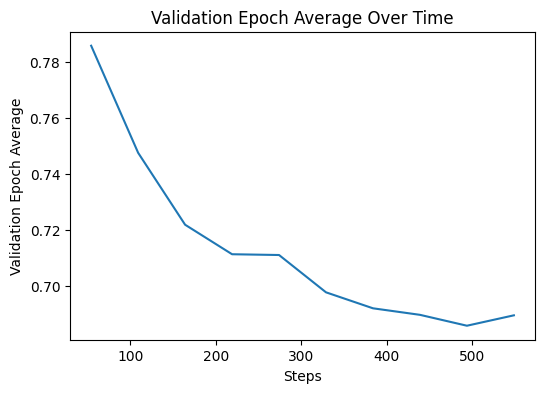

In [17]:
# Create plots
utils.plot_pl_logs(
    './lightning_logs/version_2',
    'validation_epoch_average',
    './plots/contrastive')

# Download plots
if DOWNLOAD_FILES:
    files.download('./plots/contrastive/validation_epoch_average.pdf')

#### Contrastive learning evaluation

In [18]:
# Set model to evaluation mode
siamese_lightning_module.eval()

# Extract random query sample
query = list(queries.keys())[0]
# Get the list of relevant docids for the query
docids_list = queries[query]['docids_list']

# Compute top-k docids
top_k_ids = eval_utils.top_k_docids_siamese(
    siamese_lightning_module, queries[query], documents, k=K1)

# Print top-k docids and relevant docid
print(f"Top {K1} ids:", top_k_ids)
print("Relevant ids:", docids_list)
print("Common elements", np.isin(top_k_ids, docids_list).sum())

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Top 10 ids: ['7484927' '7623633' '7230752' '2387968' '5795287' '7533642' '7688579'
 '4600832' '7675724' '7179731']
Relevant ids: ['7867446', '3368049', '4778576', '2914344', '2045120', '7867439', '6110464', '2045118', '7867440', '8699805']
Common elements 0


In [19]:
# Change return type to 'id' to get query IDs
triplets_dataset.set_ret_type('id')
# Randomly select N triplets from validation set
selected_triplets = random.sample(list(train_set_sc), 50)
# Extract queries from the selected triplets
random_queries = [triplet[0] for triplet in selected_triplets]

# Compute metrics for K1
running_mean_AP, running_mean_PatK1, running_mean_RatK1, running_mean_nDCG = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K1, model_type='siamese')
# Compute metrics for K2
_, running_mean_PatK2, running_mean_RatK2, _ = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K2, model_type='siamese')

# Print mean average precision
print("Mean Average Precision (MAP):", running_mean_AP)
# Print ndcg
print("Normalized Discounted Cumulative Gain (NDCG):", running_mean_nDCG)
# Print mean precision at k1
print(f"Mean Precison@{K1}", running_mean_PatK1)
# Print mean recall at k1
print(f"Mean Recall@{K1}", running_mean_RatK1)
# Print mean precision at k2
print(f"Mean Precison@{K2}", running_mean_PatK2)
# Print mean recall at k2
print(f"Mean Recall@{K2}", running_mean_RatK2)

Computing Mean Metrics:   0%|          | 0/50 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Mean Metrics:   0%|          | 0/50 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Mean Average Precision (MAP): 0.0
Normalized Discounted Cumulative Gain (NDCG): 0.0
Mean Precison@10 0.0
Mean Recall@10 0.0
Mean Precison@100 0.001
Mean Recall@100 0.009999999999999998


In [20]:
# Change return type to 'id' to get query IDs
triplets_dataset.set_ret_type('id')
# Randomly select N triplets from validation set
selected_triplets = random.sample(list(valid_set_sc), 50)
# Extract queries from the selected triplets
random_queries = [triplet[0] for triplet in selected_triplets]

# Compute metrics for K1
running_mean_AP, running_mean_PatK1, running_mean_RatK1, running_mean_nDCG = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K1, model_type='siamese')
# Compute metrics for K2
_, running_mean_PatK2, running_mean_RatK2, _ = eval_utils.compute_Mean_metrics(
    siamese_net, random_queries, queries, documents, k=K2, model_type='siamese')

# Print mean average precision
print("Mean Average Precision (MAP):", running_mean_AP)
# Print ndcg
print("Normalized Discounted Cumulative Gain (NDCG):", running_mean_nDCG)
# Print mean precision at k1
print(f"Mean Precison@{K1}", running_mean_PatK1)
# Print mean recall at k1
print(f"Mean Recall@{K1}", running_mean_RatK1)
# Print mean precision at k2
print(f"Mean Precison@{K2}", running_mean_PatK2)
# Print mean recall at k2
print(f"Mean Recall@{K2}", running_mean_RatK2)

Computing Mean Metrics:   0%|          | 0/50 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 10 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Mean Metrics:   0%|          | 0/50 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Computing Top 100 DocIDs:   0%|          | 0/67869 [00:00<?, ?it/s]

Mean Average Precision (MAP): 0.0
Normalized Discounted Cumulative Gain (NDCG): 0.0
Mean Precison@10 0.0
Mean Recall@10 0.0
Mean Precison@100 0.0008000000000000003
Mean Recall@100 0.008


#### Indexing and retrival using DSI approach

In [21]:
# HYPERPARAMETERS
d_model = 120
nhead = 4
nhid = 120
nlayers = 3
dropout = 0.2

# Define hyperparameters
hparams = {
    "learning_rate": 0.0005,
    "batch_size": 1024,
    "embedding_size": d_model,
    "number_of_layers": nlayers,
    "dropout": dropout
}

# Initialize transformer model
bt_model = s2s_transf.BaseTransformer(
    ntoken=dd_dataset.tokenizer.vocab_size, d_model=d_model,
    nhead=nhead, nhid=nhid, nlayers=nlayers, dropout=dropout,
    teacher_forcing_prob=1, hparams=hparams)

# Load weights if they exist
#if os.path.exists(BT_MOD_PATH):
#    bt_model.load_state_dict(torch.load(BT_MOD_PATH, map_location=bt_model.device))

/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Indexing - we train the model for the indexing task

In [22]:
# Creating dataloader
data_loader_dd = DataLoader(
    dd_dataset, batch_size=1024, shuffle=True, num_workers=2)

# Initialize TensorBoard logger
logger = TensorBoardLogger('tb_logs', name='my_model')
# For hyperparameters optimization
logger.log_hyperparams(hparams)

# Training the model
trainer = Trainer(max_epochs=400, logger=logger)
trainer.fit(bt_model, data_loader_dd)

# Start TensorBoard within the notebook
# Make sure this directory matches your logger's directory
%tensorboard --logdir tb_logs/

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name                | Type               | Params
-----------------------------------------------------------
0 | model               | Transformer        | 701 K 
1 | src_tok_emb         | Embedding          | 3.8 M 
2 | tgt_tok_emb         | Embedding          | 1.6 K 
3 | positional_encoding | PositionalEncoding | 0     
4 | relu                | ReLU               | 0     
5 | output_layer        | Linear             | 1.6 K 
-----------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.177    Total estimated model params size (MB)
/Users/alirezarafiei/

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
I0502 22:29:24.642650 12316356608 plugin.py:429] Monitor runs begin
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

train_accuracy_step data not found in logs


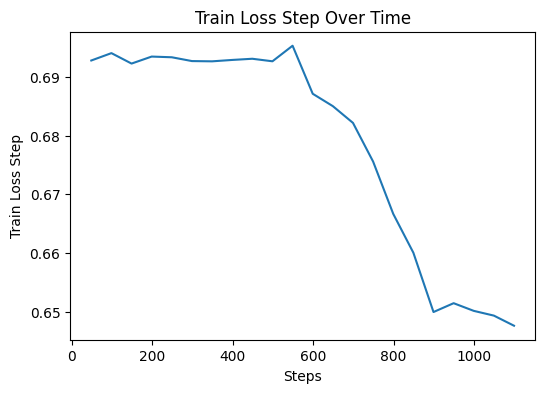

In [23]:
# Create plots
utils.plot_pl_logs(
    './lightning_logs/version_0', 'train_loss_step', './plots/indexing')
utils.plot_pl_logs(
    './lightning_logs/version_0', 'train_accuracy_step', './plots/indexing')

# Download plots
if DOWNLOAD_FILES:
    files.download('./plots/indexing/train_loss_step.pdf')
    files.download('./plots/indexing/train_accuracy_epoch.pdf')

#### Retrieval - we train the model for the retrieval task

In [8]:
# Define split ratios
split_ratios = (0.7, 0.2)  # 70% training, 20% validation, 10% testing

# Splitting the dataset
train_size, val_size, test_size = utils.calculate_split_sizes(
    len(ret_dataset), *split_ratios)
train_dataset, val_dataset, test_dataset = random_split(
    ret_dataset, [train_size, val_size, test_size])

# Creating dataloaders
train_dataloader = DataLoader(
    train_dataset, batch_size=1024, shuffle=True, num_workers=2)
val_dataloader = DataLoader(
    val_dataset, batch_size=1024, shuffle=False, num_workers=2)
test_dataloader = DataLoader(
    test_dataset, batch_size=1024, shuffle=False, num_workers=2)

In [25]:
# Training the model
trainer = pl.Trainer(max_epochs=300)
trainer.fit(bt_model, train_dataloader, val_dataloader)

# Initialize TensorBoard logger
logger = TensorBoardLogger('tb_logs', name='my_model')

# Start TensorBoard within the notebook
%tensorboard --logdir lightning_logs/

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | model               | Transformer        | 701 K 
1 | src_tok_emb         | Embedding          | 3.8 M 
2 | tgt_tok_emb         | Embedding          | 1.6 K 
3 | positional_encoding | PositionalEncoding | 0     
4 | relu                | ReLU               | 0     
5 | output_layer        | Linear             | 1.6 K 
-----------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.177    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


Reusing TensorBoard on port 6006 (pid 21855), started 11:42:30 ago. (Use '!kill 21855' to kill it.)

In [26]:
# Save model weights
torch.save(bt_model.state_dict(), BT_MOD_PATH)
# Download model weights
if DOWNLOAD_FILES:
    files.download(BT_MOD_PATH)

train_accuracy_step data not found in logs
val_accuracy data not found in logs


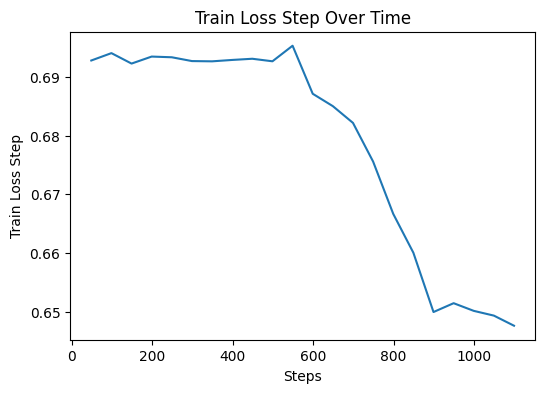

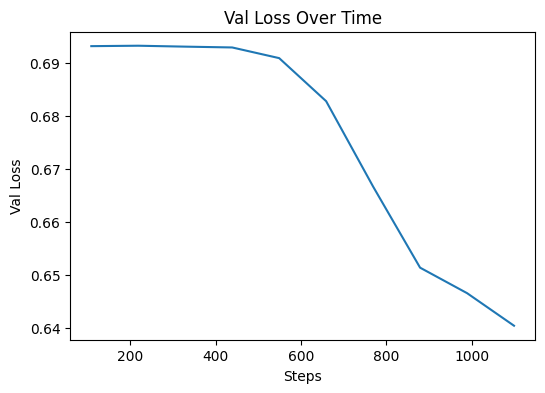

In [27]:
# Create plots
utils.plot_pl_logs(
    './lightning_logs/version_0', 'train_loss_step', './plots/retrieval')
utils.plot_pl_logs(
    './lightning_logs/version_0', 'train_accuracy_step', './plots/retrieval')
utils.plot_pl_logs(
    './lightning_logs/version_0', 'val_loss', './plots/retrieval')
utils.plot_pl_logs(
    './lightning_logs/version_0', 'val_accuracy', './plots/retrieval')

# Download plots
if DOWNLOAD_FILES: files.download('./plots/retrieval/train_loss_step.pdf')
if DOWNLOAD_FILES: files.download('./plots/retrieval/train_accuracy_epoch.pdf')
if DOWNLOAD_FILES: files.download('./plots/retrieval/val_loss.pdf')
if DOWNLOAD_FILES: files.download('./plots/retrieval/val_accuracy.pdf')

In [6]:
# Instantiate your model
# HYPERPARAMETERS
d_model = 120
nhead = 4
nhid = 120
nlayers = 3
dropout = 0.2

# Define hyperparameters
hparams = {
    "learning_rate": 0.0005,
    "batch_size": 1024,
    "embedding_size": d_model,
    "number_of_layers": nlayers,
    "dropout": dropout
}

bt_model = s2s_transf.BaseTransformer(
    ntoken=dd_dataset.tokenizer.vocab_size, d_model=d_model,
    nhead=nhead, nhid=nhid, nlayers=nlayers, dropout=dropout,
    teacher_forcing_prob=1, hparams=hparams)

# Load the model's state dictionary
bt_model.load_state_dict(torch.load(BT_MOD_PATH))

/Users/alirezarafiei/miniforge3/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [7]:
# Set model to evaluation mode
bt_model.eval()

# Extract random query sample
query = ret_dataset[random.randint(0, len(ret_dataset))][0]
# Get the list of relevant docids for the query
docids_list = queries[ret_dataset.query_ids[query]]['docids_list']

# Compute top-k docids
top_k_ids = eval_utils.top_k_docids(
    bt_model.to('cpu'), query, k=K1, max_length=10,
    decode_docid_fn=ret_dataset.decode_docid)

# Print top-k docids and relevant docid
print(f"Top {K1} ids:", top_k_ids)
print("Relevant ids:", docids_list)
print("Common elements", np.isin(top_k_ids, docids_list).sum())

Top 10 ids: ['552224' '152224' '752224' '452224' '852224' '352224' '252224' '652224'
 '952224' '052224']
Relevant ids: ['3162374', '5682038', '571854', '4506221', '5682040', '7125278', '3742048', '1047476', '5682042', '5997617']
Common elements 0


In [11]:
# Set model to evaluation mode
bt_model.eval()

# Compute metrics for K1
running_mean_AP, running_mean_PatK1, running_mean_RatK1, running_mean_nDCG = eval_utils.compute_Mean_metrics(
    bt_model.to('cpu'), {query for query, _ in test_dataset}, queries,
    documents, trie_data, ret_dataset, k=K1)
# Compute metrics for K2
_, running_mean_PatK2, running_mean_RatK2, _ = eval_utils.compute_Mean_metrics(
    bt_model.to('cpu'), {query for query, _ in test_dataset}, queries,
    documents, trie_data, ret_dataset, k=K2)

# Print mean average precision
print("Mean Average Precision (MAP):", running_mean_AP)
# Print ndcg
print("Normalized Discounted Cumulative Gain (NDCG):", running_mean_nDCG)
# Print mean precision at k1
print(f"Mean Precison@{K1}", running_mean_PatK1)
# Print mean recall at k1
print(f"Mean Recall@{K1}", running_mean_RatK1)
# Print mean precision at k2
print(f"Mean Precison@{K2}", running_mean_PatK2)
# Print mean recall at k2
print(f"Mean Recall@{K2}", running_mean_RatK2)

Computing Mean Metrics:   0%|          | 0/4533 [00:00<?, ?it/s]

Computing Mean Metrics:   0%|          | 0/4533 [00:00<?, ?it/s]

Mean Average Precision (MAP): 0.06841630213294889
Normalized Discounted Cumulative Gain (NDCG): 0.09062290802199224
Mean Precison@10 0.09133024487094614
Mean Recall@10 0.09133024487094614
Mean Precison@100 0.01671078755790863
Mean Recall@100 0.16710787557908666


In [12]:
# Set model to evaluation mode
bt_model.eval()

# Compute metrics for K1
running_mean_AP, running_mean_PatK1, running_mean_RatK1, running_mean_nDCG = eval_utils.compute_Mean_metrics(
    bt_model.to('cpu'), {query for query, _ in train_dataset},
    queries, documents, trie_data, ret_dataset, k=K1)
# Compute mean metrics for K2
_, running_mean_PatK2, running_mean_RatK2, _ = eval_utils.compute_Mean_metrics(
    bt_model.to('cpu'), {query for query, _ in train_dataset},
    queries, documents, trie_data, ret_dataset, k=K2)

# Print mean average precision
print("Mean Average Precision (MAP):", running_mean_AP)
# Print ndcg
print("Normalized Discounted Cumulative Gain (NDCG):", running_mean_nDCG)
# Print mean precision at k1
print(f"Mean Precison@{K1}", running_mean_PatK1)
# Print mean recall at k1
print(f"Mean Recall@{K1}", running_mean_RatK1)
# Print mean precision at k2
print(f"Mean Precison@{K2}", running_mean_PatK2)
# Print mean recall at k2
print(f"Mean Recall@{K2}", running_mean_RatK2)

Computing Mean Metrics:   0%|          | 0/6980 [00:00<?, ?it/s]

Computing Mean Metrics:   0%|          | 0/6980 [00:00<?, ?it/s]

Mean Average Precision (MAP): 0.06825810252865852
Normalized Discounted Cumulative Gain (NDCG): 0.09093597631969048
Mean Precison@10 0.09177650429799433
Mean Recall@10 0.09177650429799433
Mean Precison@100 0.0167893982808023
Mean Recall@100 0.16789398280802267


### TRIE: Constraint the decoding at inference time to generate only existent docids

In [9]:
# Create trie
trie_data = trie.Trie(dd_dataset.docid_pad_token)

# Iterate over dataset
for idx in range(len(dd_dataset)):
    # Insert sequence of docid tokens
    sequence = dd_dataset[idx][1].tolist()
    trie_data.insert(sequence)

In [10]:
# Example usage (returns the list of possible next tokens given the current ones)
trie_data.get_next_tokens([12, 2, 0, 8])

# 208 is the shortest docid, infact 10 (the eos)
# is a possible next token for this sequence

[8, 9, 0, 6, 4, 2, 1, 5, 3, 7, 10]

In [32]:
# Query is the same as before
# Extract top-k docids
top_k_ids = eval_utils.top_k_beam_search(
    bt_model.to('cpu'), query, trie_data, k=K1, max_length=10,
    decode_docid_fn=ret_dataset.decode_docid)

# Print top-k docids and relevant docid
print(f"Top {K1} ids:", top_k_ids)
print("Relevant ids:", docids_list)
print("Common elements", np.isin(top_k_ids, docids_list).sum())

Top 10 ids: ['1780096' '1788110' '177017' '1780864' '1789518' '1771141' '1777803'
 '1789553' '1777780' '1779157']
Relevant ids: ['1082759', '3285391', '8593186', '1491087', '5749656', '7151972', '4778215', '5818075', '5475099', '7063168']
Common elements 0


### pyterrier-based approaches

In [5]:
import pyterrier as pt
if not pt.started():
    pt.init()
import string

PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [15]:
docs = pd.DataFrame([
    {"docno": doc_id, "text": details['raw']}
    for doc_id, details in documents.items()
])

indexer = pt.DFIndexer("./materials/index_pt/index", overwrite=True)
index_ref = indexer.index(docs["text"], docs["docno"])

quer = pd.DataFrame([{"qid": str(qid), "query": details['raw']} for qid, details in queries.items()])
qrels = pd.DataFrame([{"qid": str(qid), "docno": docno, "label": 1} for qid, details in queries.items() for docno in details['docids_list']])

translator = str.maketrans('', '', string.punctuation)
def remove_punctuation(text):
    text_no_punctuation = text.translate(translator)
    return text_no_punctuation

quer['query'] = quer['query'].apply(remove_punctuation)


In [16]:
# Load the index
index = pt.IndexFactory.of(index_ref)

# Create a BM25 retrieval model
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")

pl2 = pt.BatchRetrieve(index, wmodel="PL2")

evaluation = pt.Experiment(
    [bm25, tf_idf, pl2],
    quer,
    qrels,
    eval_metrics=['map', 'ndcg', 'P', 'recall'],
    round=4,
    verbose="true"
)

print(evaluation)

pt.Experiment:   0%|          | 0/3 [00:00<?, ?system/s]

pt.Experiment: 100%|██████████| 3/3 [03:05<00:00, 61.91s/system]

         name     map    ndcg     P@5    P@10    P@15    P@20    P@30  P@100  \
0    BR(BM25)  0.9456  0.9751  0.9614  0.9167  0.6399  0.4853  0.3264  0.099   
1  BR(TF_IDF)  0.9458  0.9752  0.9617  0.9171  0.6400  0.4854  0.3264  0.099   
2     BR(PL2)  0.9378  0.9720  0.9552  0.9043  0.6368  0.4843  0.3261  0.099   

    P@200  ...  P@1000     R@5    R@10    R@15    R@20    R@30   R@100  \
0  0.0496  ...    0.01  0.4807  0.9167  0.9599  0.9706  0.9791  0.9896   
1  0.0496  ...    0.01  0.4808  0.9171  0.9601  0.9708  0.9792  0.9896   
2  0.0496  ...    0.01  0.4776  0.9043  0.9553  0.9686  0.9784  0.9896   

    R@200   R@500  R@1000  
0  0.9923  0.9944  0.9952  
1  0.9922  0.9944  0.9952  
2  0.9924  0.9944  0.9952  

[3 rows x 21 columns]
